In [18]:
from gp_diffscales_withavgloss_fixkernel import*
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:

# 1. Generate synthetic data
N, D, T, K, P = 100, 5, 50, 3, 5  # Example dimensions
sim_data = generate_synthetic_data(N, D, T, K, P, return_true_params=True)

# 2. Compute smoothed prevalence
prevalence_t = compute_smoothed_prevalence(sim_data['Y'], window_size=5)

# 3. Initialize model
model = AladynSurvivalFixedKernels(
    N=N, D=D, T=T, K=K, P=P,
    G=sim_data['G'],
    Y=sim_data['Y'],
    prevalence_t=prevalence_t
)

# 4. Fit model
history = model.fit(
    event_times=sim_data['event_times'],
    num_epochs=1000,
    learning_rate=1e-3,
    lambda_reg=1e-2
)


Epoch 0, Loss: 9724.2266
Epoch 100, Loss: 2677.3079
Epoch 200, Loss: 2355.7271
Epoch 300, Loss: 2210.4985
Epoch 400, Loss: 2108.8328
Epoch 500, Loss: 2029.3353
Epoch 600, Loss: 1964.7473
Epoch 700, Loss: 1911.3972
Epoch 800, Loss: 1867.1554
Epoch 900, Loss: 1830.5613


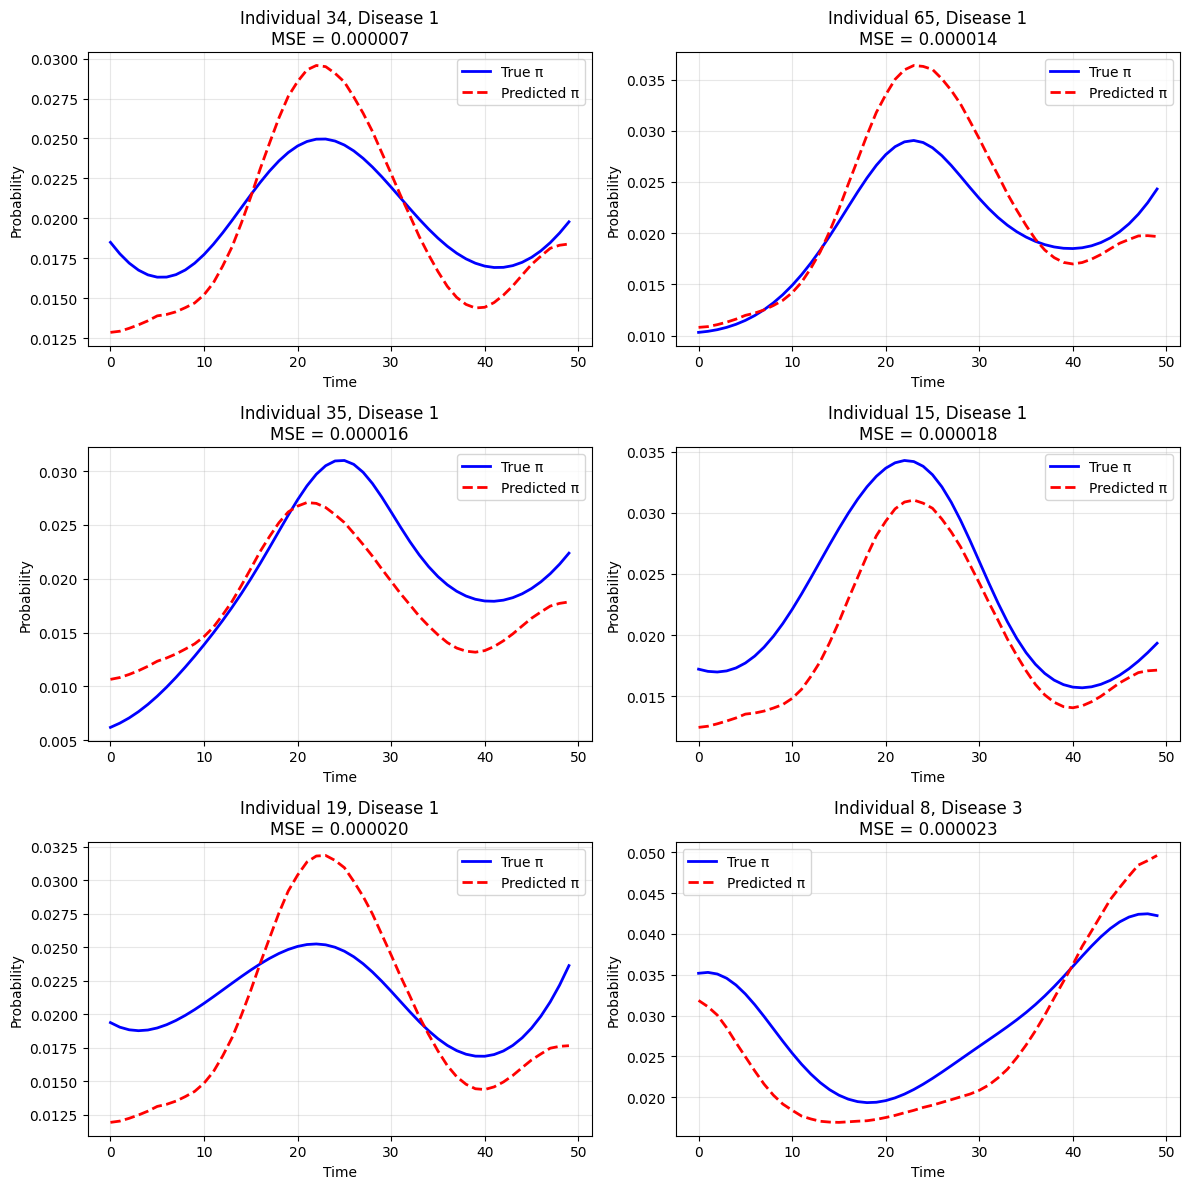

In [20]:
plot_best_matches(sim_data['pi'], model.forward()[0], n_samples=6)

In [17]:
sim_data['length_scales']

array([16.38209535, 16.16919643, 14.13048539])

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_67564/4267676013.py:67: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


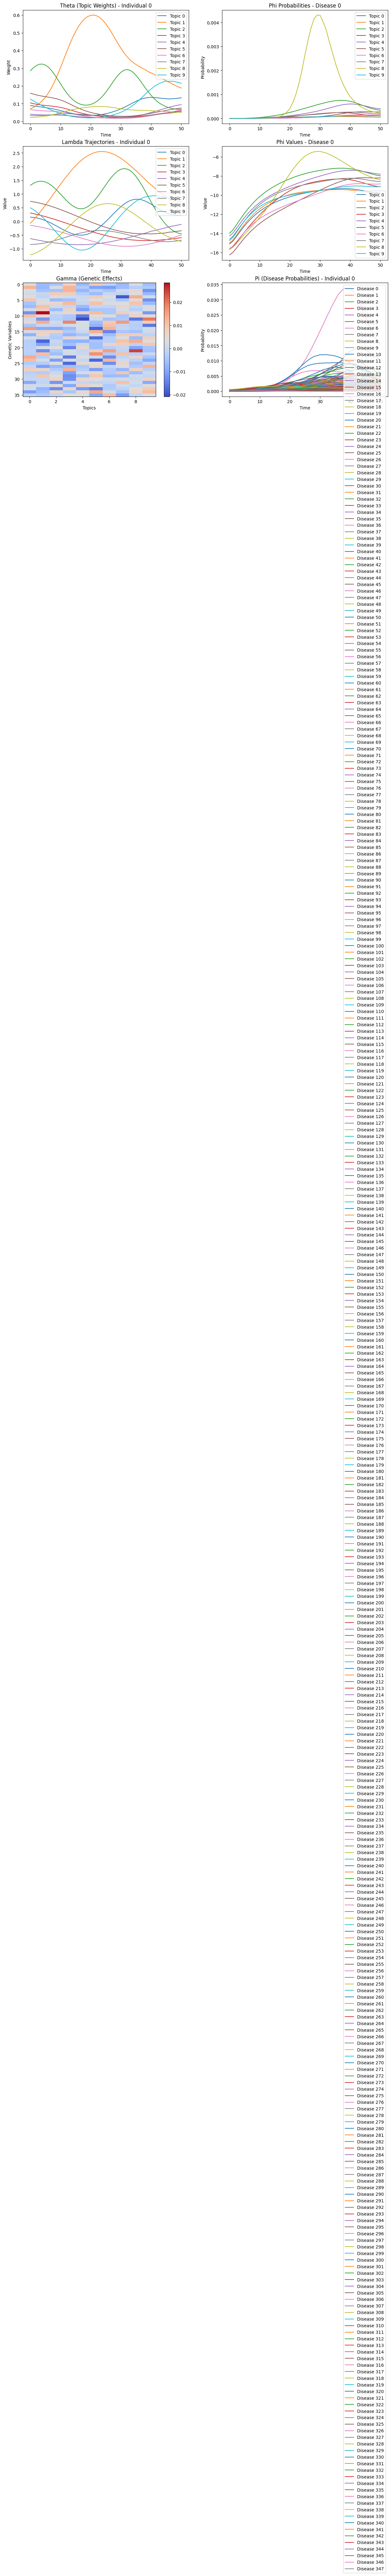

In [ ]:
K=10
pi_pred, theta_pred, phi_pred = model.forward()

# Plot predicted theta only
pi_pred, theta, phi_prob = model.forward()

# Convert predictions to numpy
pi_pred_np = pi_pred.detach().numpy()

fig, axes = plt.subplots(3, 2, figsize=(15, 16))  # Made taller for extra row

# 1. Plot theta (topic weights) for first few individuals
theta_np = theta.detach().numpy()
for k in range(K):
    axes[0, 0].plot(theta_np[0, k, :], label=f'Topic {k}')
axes[0, 0].set_title('Theta (Topic Weights) - Individual 0')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Weight')
axes[0, 0].legend()

# 2. Plot phi probabilities for first few diseases
phi_prob_np = phi_prob.detach().numpy()
for k in range(K):
    axes[0, 1].plot(phi_prob_np[k, 0, :], label=f'Topic {k}')
axes[0, 1].set_title('Phi Probabilities - Disease 0')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Probability')
axes[0, 1].legend()

# 3. Plot lambda trajectories
lambda_np = model.lambda_.detach().numpy()
for k in range(K):
    axes[1, 0].plot(lambda_np[0, k, :], label=f'Topic {k}')
axes[1, 0].set_title('Lambda Trajectories - Individual 0')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()

# 4. Plot raw phi values
phi_np = model.phi.detach().numpy()
for k in range(K):
    axes[1, 1].plot(phi_np[k, 0, :], label=f'Topic {k}')
axes[1, 1].set_title('Phi Values - Disease 0')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()

# 5. Plot gamma (genetic effects) as heatmap
gamma_np = model.gamma.detach().numpy()
im = axes[2, 0].imshow(gamma_np, aspect='auto', cmap='coolwarm')
axes[2, 0].set_title('Gamma (Genetic Effects)')
axes[2, 0].set_xlabel('Topics')
axes[2, 0].set_ylabel('Genetic Variables')
plt.colorbar(im, ax=axes[2, 0])

# 6. Plot final survival probabilities for first individual
pi_np = pi_pred.detach().numpy()
for d in range(D):
    axes[2, 1].plot(pi_pred_np[0, d, :], label=f'Disease {d}')
axes[2, 1].set_title('Pi (Disease Probabilities) - Individual 0')
axes[2, 1].set_xlabel('Time')
axes[2, 1].set_ylabel('Probability')
axes[2, 1].legend()



plt.tight_layout()
plt.show()




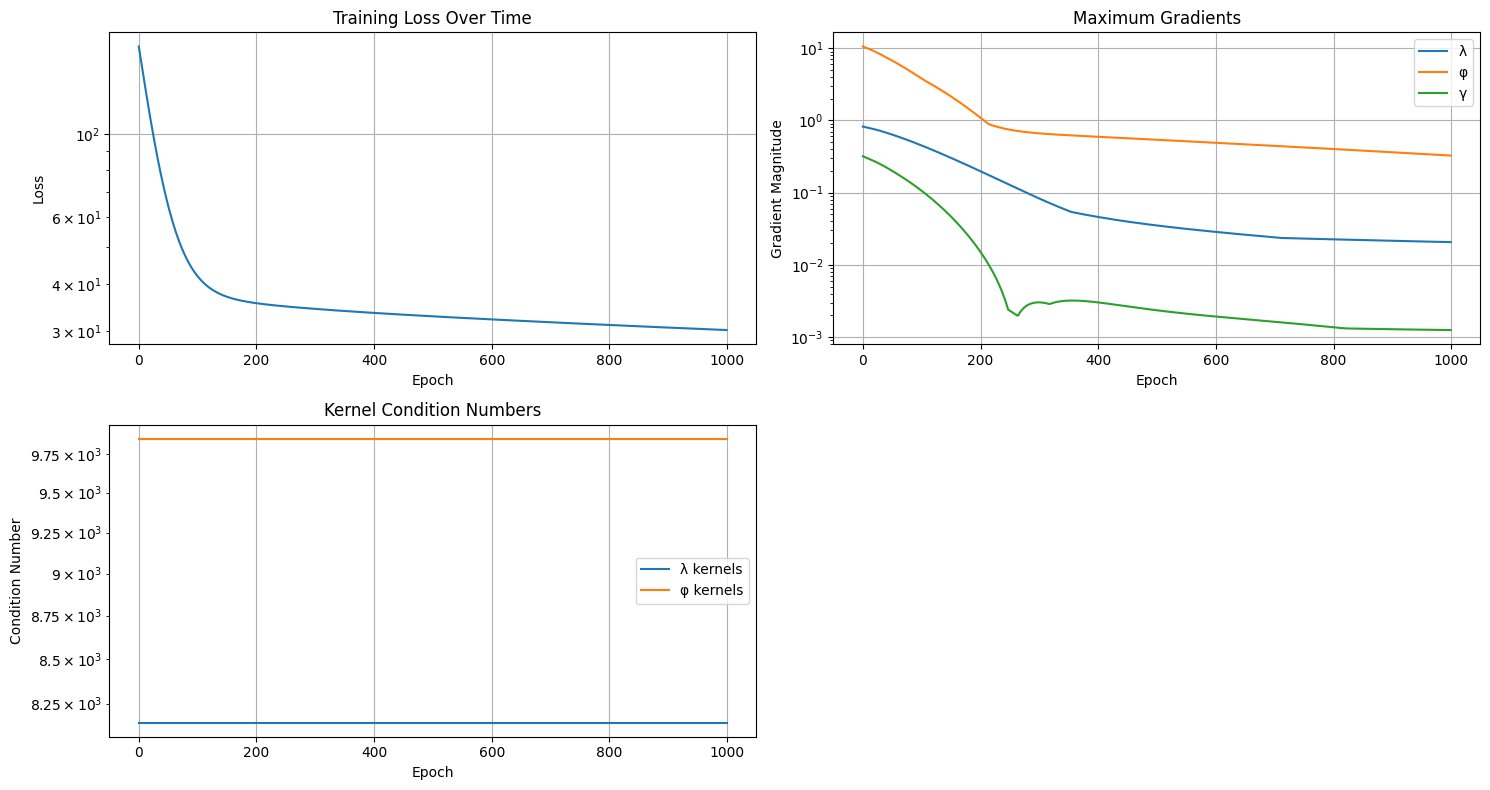

In [9]:

# 5. Plot diagnostics
plot_training_diagnostics(history)



In [11]:
from gp_softmax_torch_works_play_matrprev import *

In [13]:
modelold = AladynSurvivalModel(
    N=N, D=D, T=T, K=K, P=P,
    G=sim_data['G'],
    Y=sim_data['Y'],
    prevalence_t=prevalence_t
)

# 4. Fit model
history = modelold.fit(
    event_times=sim_data['event_times'],
    num_epochs=1000,
    learning_rate=1e-3,
    lambda_reg=1e-2
)


Epoch 0
Loss: 9738.2852
Length scales: [16.665667 16.665667 16.665667]
Amplitudes: [1.0010005 1.0010005 1.0010005]
Max gradients - λ: 65.7662, φ: 52.5432, γ: 29.6390
Mean condition number: 9847.14
Loss change: inf

Epoch 100
Loss: 2487.7314
Length scales: [16.562628 16.561583 16.563168]
Amplitudes: [1.1168902 1.1167588 1.1163563]
Max gradients - λ: 15.3729, φ: 10.5609, γ: 6.8911
Mean condition number: 6103.38
Loss change: 6.7720

Epoch 200
Loss: 2202.5432
Length scales: [16.470917 16.469488 16.472784]
Amplitudes: [1.2483749 1.2463672 1.2464863]
Max gradients - λ: 3.8869, φ: 8.2884, γ: 0.9308
Mean condition number: 7587.43
Loss change: 1.5295

Epoch 300
Loss: 2080.4368
Length scales: [16.392117 16.393147 16.394814]
Amplitudes: [1.3903581 1.3839128 1.3860935]
Max gradients - λ: 1.7641, φ: 7.4857, γ: 0.3741
Mean condition number: 9356.27
Loss change: 0.9946

Epoch 400
Loss: 1994.2277
Length scales: [16.321873 16.326172 16.324705]
Amplitudes: [1.5456138 1.5330716 1.5380211]
Max gradients 

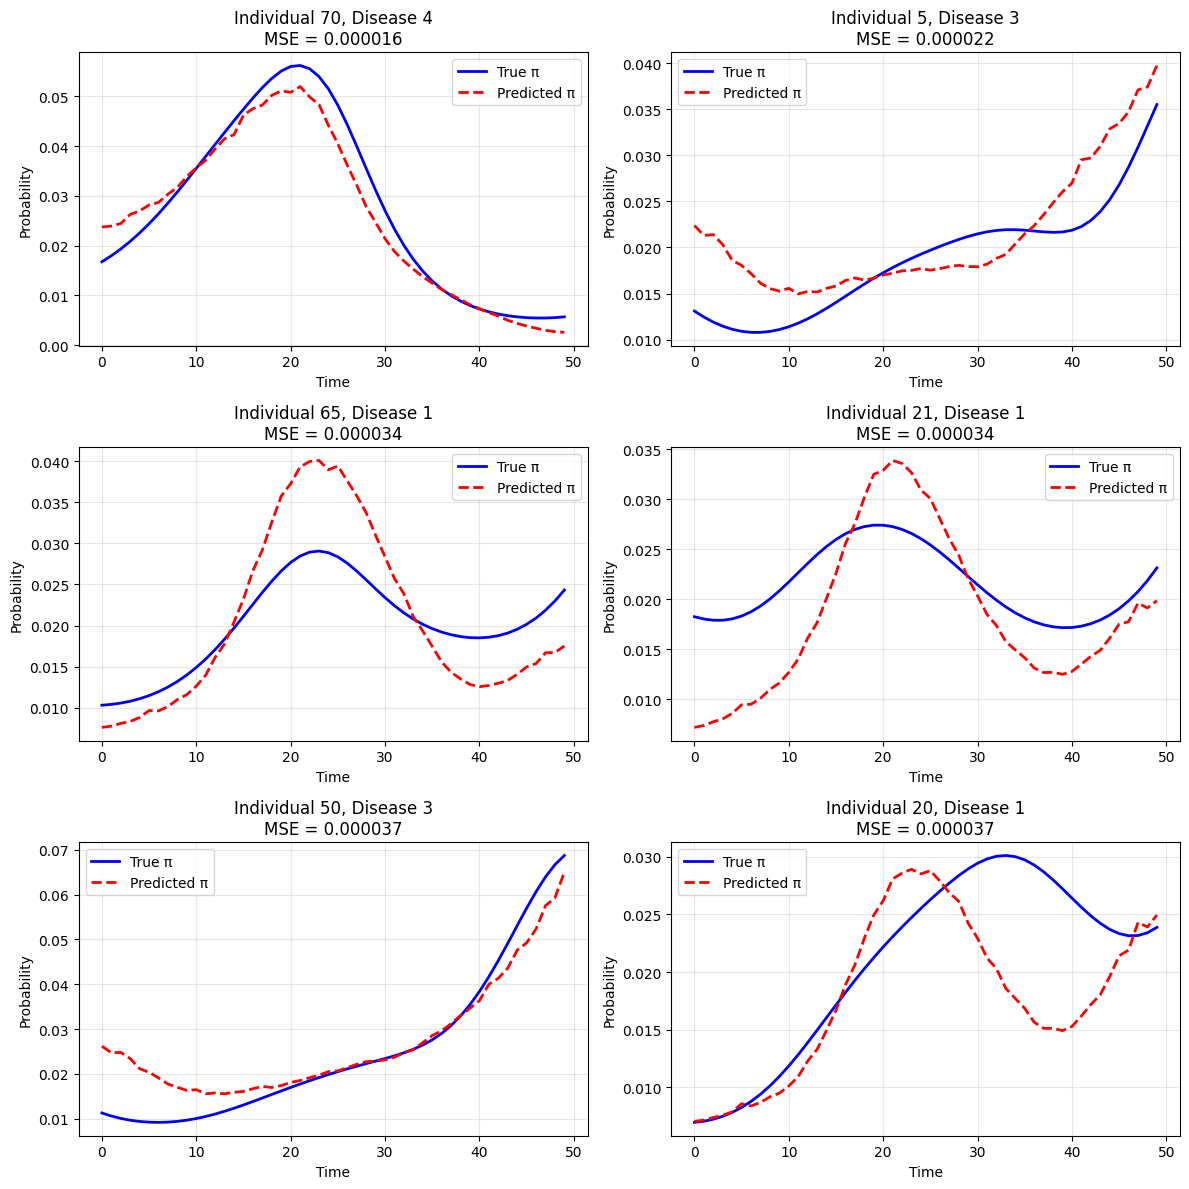

In [14]:
plot_best_matches(sim_data['pi'], modelold.forward()[0], n_samples=6)

/var/folders/2f/nxrbr3pn1msgrl4ffyj33zd00000gn/T/ipykernel_67564/4267676013.py:67: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


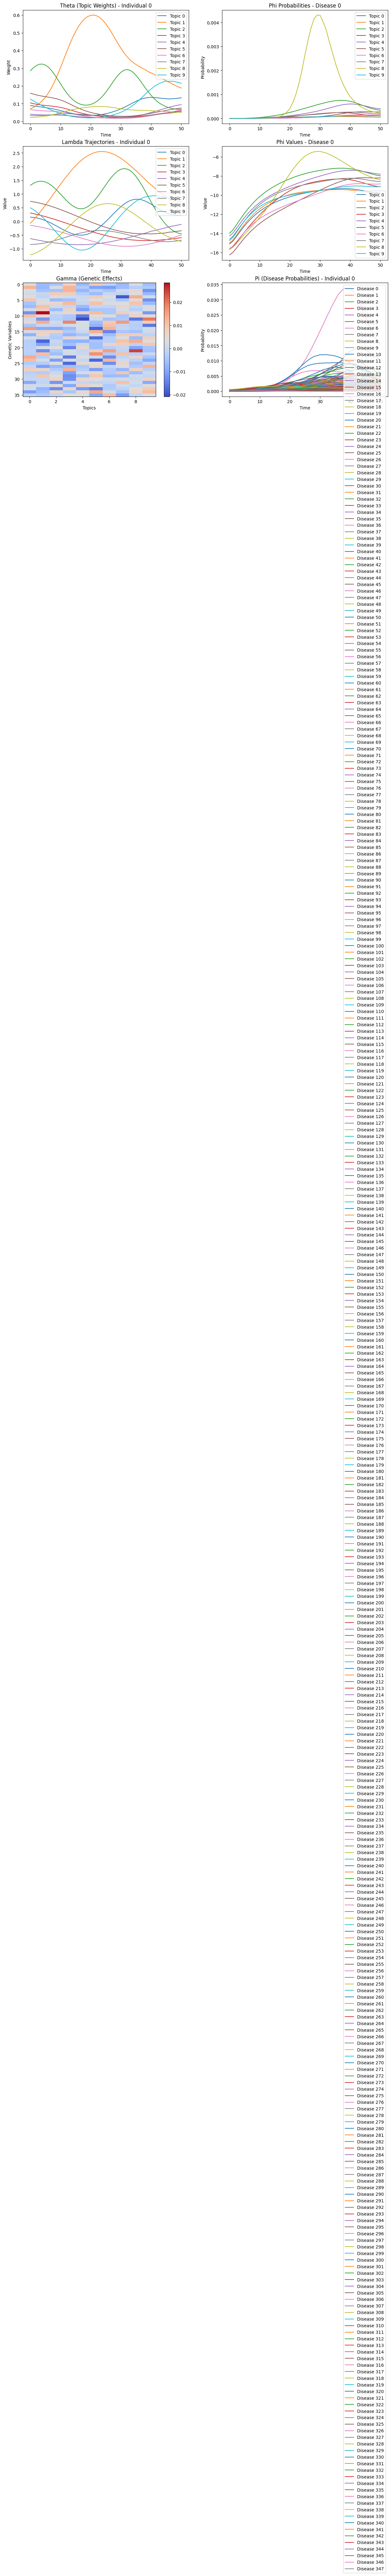

In [ ]:
K=10
pi_pred, theta_pred, phi_pred = model.forward()

# Plot predicted theta only
pi_pred, theta, phi_prob = model.forward()

# Convert predictions to numpy
pi_pred_np = pi_pred.detach().numpy()

fig, axes = plt.subplots(3, 2, figsize=(15, 16))  # Made taller for extra row

# 1. Plot theta (topic weights) for first few individuals
theta_np = theta.detach().numpy()
for k in range(K):
    axes[0, 0].plot(theta_np[0, k, :], label=f'Topic {k}')
axes[0, 0].set_title('Theta (Topic Weights) - Individual 0')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Weight')
axes[0, 0].legend()

# 2. Plot phi probabilities for first few diseases
phi_prob_np = phi_prob.detach().numpy()
for k in range(K):
    axes[0, 1].plot(phi_prob_np[k, 0, :], label=f'Topic {k}')
axes[0, 1].set_title('Phi Probabilities - Disease 0')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Probability')
axes[0, 1].legend()

# 3. Plot lambda trajectories
lambda_np = model.lambda_.detach().numpy()
for k in range(K):
    axes[1, 0].plot(lambda_np[0, k, :], label=f'Topic {k}')
axes[1, 0].set_title('Lambda Trajectories - Individual 0')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()

# 4. Plot raw phi values
phi_np = model.phi.detach().numpy()
for k in range(K):
    axes[1, 1].plot(phi_np[k, 0, :], label=f'Topic {k}')
axes[1, 1].set_title('Phi Values - Disease 0')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()

# 5. Plot gamma (genetic effects) as heatmap
gamma_np = model.gamma.detach().numpy()
im = axes[2, 0].imshow(gamma_np, aspect='auto', cmap='coolwarm')
axes[2, 0].set_title('Gamma (Genetic Effects)')
axes[2, 0].set_xlabel('Topics')
axes[2, 0].set_ylabel('Genetic Variables')
plt.colorbar(im, ax=axes[2, 0])

# 6. Plot final survival probabilities for first individual
pi_np = pi_pred.detach().numpy()
for d in range(D):
    axes[2, 1].plot(pi_pred_np[0, d, :], label=f'Disease {d}')
axes[2, 1].set_title('Pi (Disease Probabilities) - Individual 0')
axes[2, 1].set_xlabel('Time')
axes[2, 1].set_ylabel('Probability')
axes[2, 1].legend()



plt.tight_layout()
plt.show()




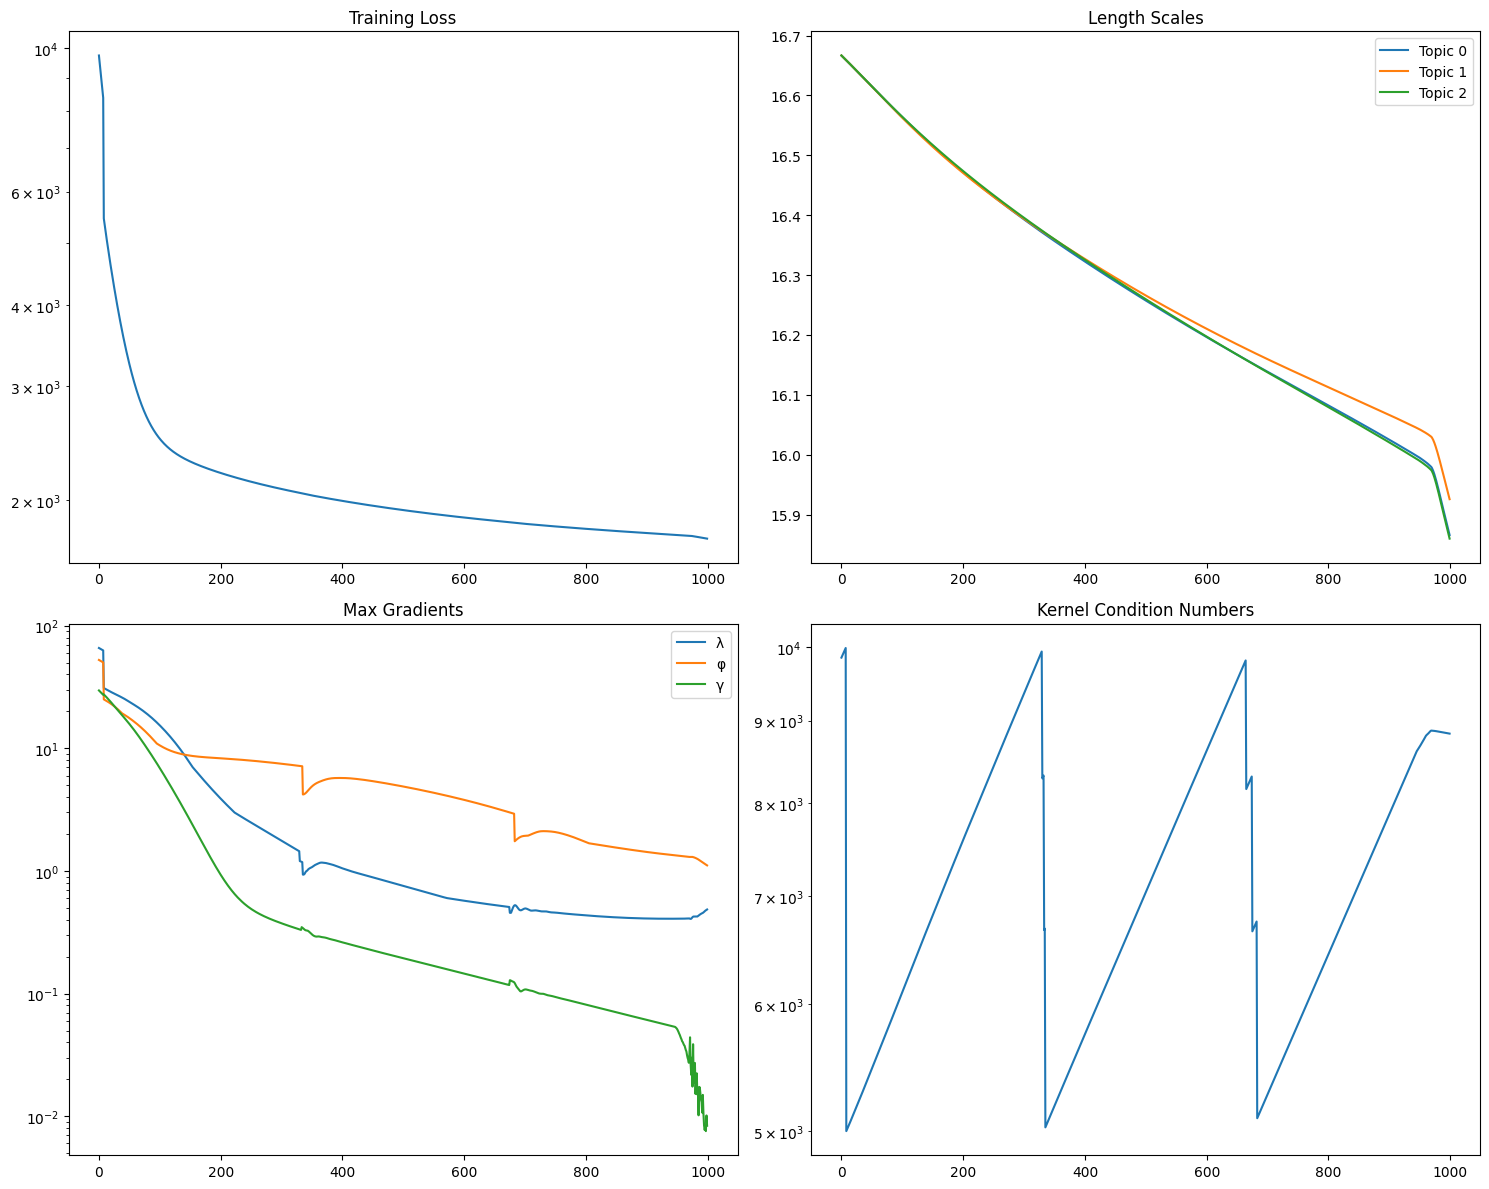

In [15]:
plot_training_diagnostics(history)

In [16]:
sim_data['length_scales']

array([16.38209535, 16.16919643, 14.13048539])

In [10]:
import rpy2.robjects as robjects
import numpy as np
import os as os
from rpy2.robjects import numpy2ri
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2
# Specify the path to your data files
data_path = "/Users/sarahurbut/tensornoulli_ehr_new/data"

# Activate automatic conversion between R and NumPy arrays
numpy2ri.activate()# Load data saved as .rds files
Y = np.array(robjects.r['readRDS'](os.path.join(data_path, 'Y.rds')))
E = np.array(robjects.r['readRDS'](os.path.join(data_path, 'event_for_aladynoulli.rds')))
G = np.array(robjects.r['readRDS'](os.path.join(data_path, 'prs.rds')))

E = E.astype(int)

# G should be float64
G = G.astype(float)
G.shape
G = G.T
print("G shape after transposition:", G.shape)

# Convert to PyTorch tensors
Y_tensor = torch.FloatTensor(Y)
E_tensor = torch.FloatTensor(E)
G_tensor = torch.FloatTensor(G)

# Get dimensions
N, D, T = Y_tensor.shape
P = G_tensor.shape[1]
T = int(E_tensor.max() + 1)  # 0-indexed time
K = 10  # number of topics

# Print shapes to verify
print("Tensor shapes:")
print(f"Y: {Y_tensor.shape}")  # [N, D]
print(f"E: {E_tensor.shape}")  # [N, D]
print(f"G: {G_tensor.shape}")  # [N, P]
print(f"Time range: 0 to {T-1}")
print(T)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
G shape after transposition: (9661, 36)
Tensor shapes:
Y: torch.Size([9661, 348, 51])
E: torch.Size([9661, 348])
G: torch.Size([9661, 36])
Time range: 0 to 50
51


In [13]:
prevalence_t = compute_smoothed_prevalence(Y, window_size=5)

# 3. Initialize model
model = AladynSurvivalFixedKernels(
    N=N, D=D, T=T, K=K, P=P,
    G=G,
    Y=Y,
    prevalence_t=prevalence_t
)

# 4. Fit model
history = model.fit(
    event_times=E,
    num_epochs=1000,
    learning_rate=1e-3,
    lambda_reg=1e-2
)

Epoch 0, Loss: 594.3116
Epoch 100, Loss: 171.9405
Epoch 200, Loss: 135.4774
Epoch 300, Loss: 128.6096
Epoch 400, Loss: 125.2767
Epoch 500, Loss: 122.8746
Epoch 600, Loss: 120.9320


KeyboardInterrupt: 